In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
import pickle
import time

In [38]:
class SequentialDataset(Dataset):
    def __init__(self, dataframe, features, target_class, target_reg):
        self.dataframe = dataframe
        self.features = features
        self.target_class = target_class
        self.target_reg = target_reg

    def __len__(self):
        return len(self.dataframe) - 1  # assuming sequences are constructed from sliding window with overlap

    def __getitem__(self, idx):
        X = self.dataframe.iloc[idx:idx+2][self.features].astype(np.float32).values
        y_class = self.dataframe.iloc[idx+1][self.target_class].astype(np.int64)
        y_reg = self.dataframe.iloc[idx+1][self.target_reg].astype(np.float32)
        return torch.tensor(X), torch.tensor(y_class), torch.tensor(y_reg)

class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_class = nn.Linear(hidden_size, num_classes)
        self.fc_reg = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]  # Get the output from the last time step
        class_output = self.fc_class(out)
        reg_output = self.fc_reg(out)
        return class_output, reg_output

def load_and_concatenate_csvs(folder_path, test_file):
    dataframes = []
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv') and file != test_file]

    for csv_file in csv_files:
        print(csv_file)
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        dataframes.append(df)

    common_columns = set(dataframes[0].columns)
    for df in dataframes[1:]:
        common_columns.intersection_update(df.columns)

    common_columns = list(common_columns)
    for i in range(len(dataframes)):
        dataframes[i] = dataframes[i][common_columns]

    for i in range(len(dataframes)):
        dataframes[i] = dataframes[i][(dataframes[i]['TOC'] != -9999) & (dataframes[i]['TOC'] != 9999)]

    concatenated_df = pd.concat(dataframes, ignore_index=True)
    concatenated_df.dropna(inplace=True)

    test_df = pd.read_csv(test_file)
    test_df = test_df[common_columns]
    test_df = test_df[(test_df['TOC'] != -9999) & (test_df['TOC'] != 9999)]
    test_df.dropna(inplace=True)


    toc_min = concatenated_df['TOC'].min()
    toc_max = concatenated_df['TOC'].max()

    print(f"Minimum TOC value: {toc_min}")
    print(f"Maximum TOC value: {toc_max}")

    return concatenated_df, test_df

def normalize_numerical_columns(train_df, test_df):
    normalization_params = {}
    for column in train_df.columns:
        if pd.api.types.is_numeric_dtype(train_df[column]):
            mean = train_df[column].mean()
            std = train_df[column].std()
            train_df[column] = (train_df[column] - mean) / std
            test_df[column] = (test_df[column] - mean) / std
            normalization_params[column] = {'mean': mean, 'std': std}
    return train_df, test_df, normalization_params

def display_categorical_columns_unique_values(df):
    for column in df.columns:
        if not pd.api.types.is_numeric_dtype(df[column]):
            print(f"Unique values in column '{column}': {df[column].unique()}")

def encode_facies_column(df):
    label_encoder = LabelEncoder()
    df['Facies_encoded'] = label_encoder.fit_transform(df['Facies'])
    return df, label_encoder

def balance_classes(df, target_column, min_samples):
    class_counts = df[target_column].value_counts()
    selected_classes = class_counts[class_counts >= min_samples].index.tolist()
    balanced_df = df[df[target_column].isin(selected_classes)]
    return balanced_df

In [39]:
folder_path = './data/'
test_file = './data/GY10HC.csv'  #specify the test csv
concatenated_df, test_df = load_and_concatenate_csvs(folder_path, test_file)
print(concatenated_df.shape)

GY10HC.csv
GY2HC.csv
GY3HC.csv
GY8HC.csv
Minimum TOC value: 0.078
Maximum TOC value: 5.97
(75533, 11)


In [40]:
concatenated_df.head()

,DEN,CNL,TOC,LLS,DTP,Facies,SP,VP,Depth,LLD,GR
0,2.505,23.230,0.878,5.753,97.951,shaly_limestone,74.540,3111.608115,2400.000,5.455,118.206
1,2.514,24.287,0.983,6.036,98.023,shaly_limestone,75.081,3109.322572,2400.125,5.718,117.383
2,2.513,25.079,1.080,6.230,98.622,shaly_limestone,75.426,3090.437494,2400.250,5.888,117.442
3,2.503,24.736,1.225,6.259,101.081,shaly_limestone,75.577,3015.256344,2400.375,5.898,118.729
4,2.482,23.207,1.350,6.150,104.007,shale,75.530,2930.428976,2400.500,5.780,120.142


In [41]:
train_df, test_df, normalization_params = normalize_numerical_columns(concatenated_df, test_df)
print(train_df.head())

        DEN       CNL       TOC       LLS       DTP           Facies  \
0  0.150606 -0.403551 -1.898182 -0.334058 -0.801651  shaly_limestone   
1  0.280675 -0.231857 -1.726617 -0.196691 -0.793690  shaly_limestone   
2  0.266223 -0.103209 -1.568124 -0.102524 -0.727460  shaly_limestone   
3  0.121702 -0.158924 -1.331200 -0.088448 -0.455575  shaly_limestone   
4 -0.181790 -0.407287 -1.126956 -0.141356 -0.132055            shale   

         SP        VP     Depth       LLD        GR  
0  0.245684  0.719287 -0.618557 -0.364912  0.593627  
1  0.261607  0.710713 -0.616603 -0.226526  0.507971  
2  0.271761  0.639870 -0.614648 -0.137075  0.514111  
3  0.276205  0.357844 -0.612694 -0.131813  0.648060  
4  0.274822  0.039632 -0.610740 -0.193903  0.795121  


In [42]:
normalization_params

{'DEN': {'mean': 2.494578859571313, 'std': 0.06919452427258971},
 'CNL': {'mean': 25.714383262944676, 'std': 6.156306217087228},
 'TOC': {'mean': 2.03971093429362, 'std': 0.6120123217596523},
 'LLS': {'mean': 6.441218328412748, 'std': 2.060178576847819},
 'DTP': {'mean': 105.20134232719475, 'std': 9.04426090445257},
 'SP': {'mean': 66.19248550964481, 'std': 33.97662535448833},
 'VP': {'mean': 2919.864084898217, 'std': 266.5752575679138},
 'Depth': {'mean': 2439.56418288695, 'std': 63.96206896251989},
 'LLD': {'mean': 6.148509340288351, 'std': 1.9004852804217327},
 'GR': {'mean': 112.50231694755934, 'std': 9.608195993937029}}

In [43]:
display_categorical_columns_unique_values(train_df)

Unique values in column 'Facies': ['shaly_limestone' 'shale' 'mudstone' 'Dolomite' 'dolomitic_limestone'
 'dolomitic_shale' 'oil_shale' 'siltstone' 'sandstone' 'shaly_ sand'
 'silty_limestone' ' shaly_ sand' ' siltstone' 'shaly_ limestone'
 'siltsty_ limestone' ' dolomitic_limestone' 'siltstone ' 'sandy_shale'
 'shaly_sand' ' mudstone' ' shaly_sand' 'silty_ limestone']


In [44]:
train_df, label_encoder = encode_facies_column(train_df)
test_df['Facies_encoded'] = label_encoder.transform(test_df['Facies'])
print(train_df.head())

        DEN       CNL       TOC       LLS       DTP           Facies  \
0  0.150606 -0.403551 -1.898182 -0.334058 -0.801651  shaly_limestone   
1  0.280675 -0.231857 -1.726617 -0.196691 -0.793690  shaly_limestone   
2  0.266223 -0.103209 -1.568124 -0.102524 -0.727460  shaly_limestone   
3  0.121702 -0.158924 -1.331200 -0.088448 -0.455575  shaly_limestone   
4 -0.181790 -0.407287 -1.126956 -0.141356 -0.132055            shale   

         SP        VP     Depth       LLD        GR  Facies_encoded  
0  0.245684  0.719287 -0.618557 -0.364912  0.593627              15  
1  0.261607  0.710713 -0.616603 -0.226526  0.507971              15  
2  0.271761  0.639870 -0.614648 -0.137075  0.514111              15  
3  0.276205  0.357844 -0.612694 -0.131813  0.648060              15  
4  0.274822  0.039632 -0.610740 -0.193903  0.795121              12  


In [45]:
test_df.head()

,DEN,CNL,TOC,LLS,DTP,Facies,SP,VP,Depth,LLD,GR,Facies_encoded
0,0.150606,-0.403551,-1.898182,-0.334058,-0.801651,shaly_limestone,0.245684,0.719287,-0.618557,-0.364912,0.593627,15
1,0.280675,-0.231857,-1.726617,-0.196691,-0.793690,shaly_limestone,0.261607,0.710713,-0.616603,-0.226526,0.507971,15
2,0.266223,-0.103209,-1.568124,-0.102524,-0.727460,shaly_limestone,0.271761,0.639870,-0.614648,-0.137075,0.514111,15
3,0.121702,-0.158924,-1.331200,-0.088448,-0.455575,shaly_limestone,0.276205,0.357844,-0.612694,-0.131813,0.648060,15
4,-0.181790,-0.407287,-1.126956,-0.141356,-0.132055,shale,0.274822,0.039632,-0.610740,-0.193903,0.795121,12


In [46]:
# test_df = test_df.reindex(columns=feature_order.append(['Facies_encoded','TOC'])) #uncomment if running inference

In [47]:
test_df.head()

,DEN,CNL,TOC,LLS,DTP,Facies,SP,VP,Depth,LLD,GR,Facies_encoded
0,0.150606,-0.403551,-1.898182,-0.334058,-0.801651,shaly_limestone,0.245684,0.719287,-0.618557,-0.364912,0.593627,15
1,0.280675,-0.231857,-1.726617,-0.196691,-0.793690,shaly_limestone,0.261607,0.710713,-0.616603,-0.226526,0.507971,15
2,0.266223,-0.103209,-1.568124,-0.102524,-0.727460,shaly_limestone,0.271761,0.639870,-0.614648,-0.137075,0.514111,15
3,0.121702,-0.158924,-1.331200,-0.088448,-0.455575,shaly_limestone,0.276205,0.357844,-0.612694,-0.131813,0.648060,15
4,-0.181790,-0.407287,-1.126956,-0.141356,-0.132055,shale,0.274822,0.039632,-0.610740,-0.193903,0.795121,12


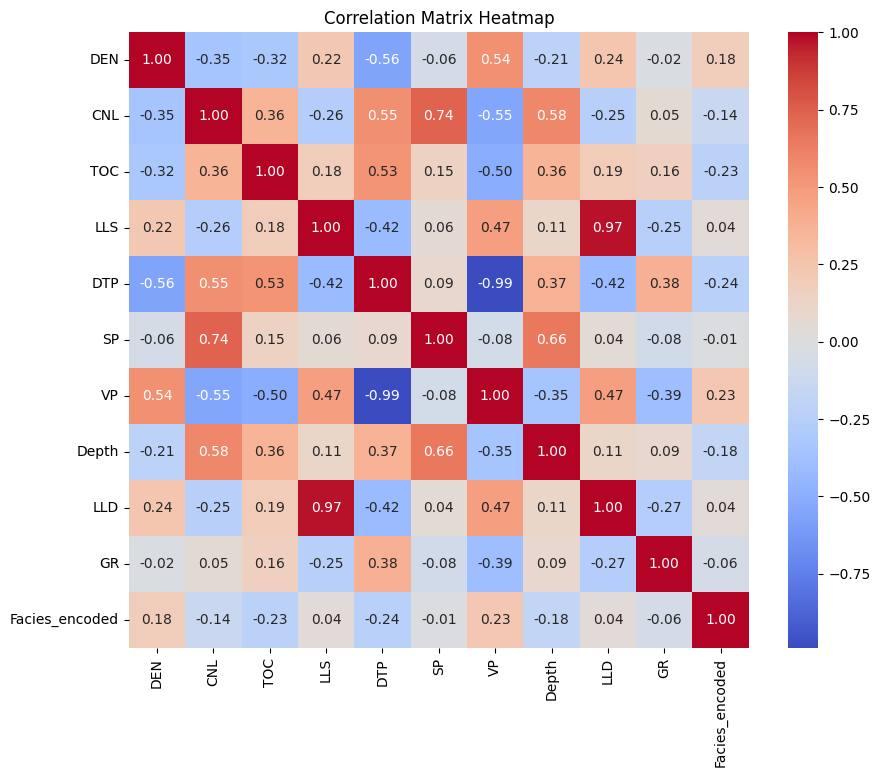

In [48]:
temp_df = train_df.copy()
temp_df.drop(columns=['Facies'], inplace=True)
corr_matrix = temp_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [49]:
min_samples = 10
balanced_df = balance_classes(train_df, 'Facies_encoded', min_samples)

In [50]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, val_index = next(sss.split(balanced_df, balanced_df['Facies_encoded']))
train_df = balanced_df.iloc[train_index]
val_df = balanced_df.iloc[val_index]

In [51]:
features = [col for col in train_df.columns if col not in ['Facies', 'Facies_encoded', 'TOC']]
target_class = 'Facies_encoded'
target_reg = 'TOC'

In [52]:
features

['DEN', 'CNL', 'LLS', 'DTP', 'SP', 'VP', 'Depth', 'LLD', 'GR']

In [53]:
train_dataset = SequentialDataset(train_df, features, target_class, target_reg)
val_dataset = SequentialDataset(val_df, features, target_class, target_reg)
test_dataset = SequentialDataset(test_df, features, target_class, target_reg)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 64
num_layers = 2
model = LSTMNet(len(features), hidden_size, num_layers, len(label_encoder.classes_)).to(device)
criterion_class = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # Decay LR by a factor of 0.1 every 10 epochs

C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.64it/s]


Epoch [1/100], Train Loss: 1.7808, Val Class Loss: 0.7294, Val Reg Loss: 0.4447


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 26.14it/s]


Epoch [2/100], Train Loss: 1.1214, Val Class Loss: 0.6915, Val Reg Loss: 0.3967


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.16it/s]


Epoch [3/100], Train Loss: 1.0778, Val Class Loss: 0.6810, Val Reg Loss: 0.3822


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.61it/s]


Epoch [4/100], Train Loss: 1.0601, Val Class Loss: 0.6750, Val Reg Loss: 0.3737


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.53it/s]


Epoch [5/100], Train Loss: 1.0469, Val Class Loss: 0.6700, Val Reg Loss: 0.3658


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.58it/s]


Epoch [6/100], Train Loss: 1.0338, Val Class Loss: 0.6650, Val Reg Loss: 0.3574


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.29it/s]


Epoch [7/100], Train Loss: 1.0198, Val Class Loss: 0.6595, Val Reg Loss: 0.3483


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.73it/s]


Epoch [8/100], Train Loss: 1.0044, Val Class Loss: 0.6534, Val Reg Loss: 0.3386


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.60it/s]


Epoch [9/100], Train Loss: 0.9879, Val Class Loss: 0.6467, Val Reg Loss: 0.3288


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.76it/s]


Epoch [10/100], Train Loss: 0.9711, Val Class Loss: 0.6400, Val Reg Loss: 0.3194


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.39it/s]


Epoch [11/100], Train Loss: 0.9554, Val Class Loss: 0.6340, Val Reg Loss: 0.3112


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.35it/s]


Epoch [12/100], Train Loss: 0.9419, Val Class Loss: 0.6288, Val Reg Loss: 0.3044


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.73it/s]


Epoch [13/100], Train Loss: 0.9306, Val Class Loss: 0.6243, Val Reg Loss: 0.2990


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.86it/s]


Epoch [14/100], Train Loss: 0.9211, Val Class Loss: 0.6203, Val Reg Loss: 0.2945


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.87it/s]


Epoch [15/100], Train Loss: 0.9129, Val Class Loss: 0.6167, Val Reg Loss: 0.2906


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.83it/s]


Epoch [16/100], Train Loss: 0.9057, Val Class Loss: 0.6135, Val Reg Loss: 0.2871


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.67it/s]


Epoch [17/100], Train Loss: 0.8993, Val Class Loss: 0.6107, Val Reg Loss: 0.2840


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.92it/s]


Epoch [18/100], Train Loss: 0.8935, Val Class Loss: 0.6082, Val Reg Loss: 0.2811


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.51it/s]


Epoch [19/100], Train Loss: 0.8882, Val Class Loss: 0.6058, Val Reg Loss: 0.2785


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.31it/s]


Epoch [20/100], Train Loss: 0.8833, Val Class Loss: 0.6037, Val Reg Loss: 0.2760


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.36it/s]


Epoch [21/100], Train Loss: 0.8787, Val Class Loss: 0.6016, Val Reg Loss: 0.2737


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 26.05it/s]


Epoch [22/100], Train Loss: 0.8742, Val Class Loss: 0.5997, Val Reg Loss: 0.2714


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.78it/s]


Epoch [23/100], Train Loss: 0.8699, Val Class Loss: 0.5978, Val Reg Loss: 0.2693


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:20<00:00, 23.57it/s]


Epoch [24/100], Train Loss: 0.8657, Val Class Loss: 0.5959, Val Reg Loss: 0.2672


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:20<00:00, 23.56it/s]


Epoch [25/100], Train Loss: 0.8616, Val Class Loss: 0.5941, Val Reg Loss: 0.2651


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.82it/s]


Epoch [26/100], Train Loss: 0.8575, Val Class Loss: 0.5923, Val Reg Loss: 0.2630


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.63it/s]


Epoch [27/100], Train Loss: 0.8535, Val Class Loss: 0.5905, Val Reg Loss: 0.2610


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.77it/s]


Epoch [28/100], Train Loss: 0.8494, Val Class Loss: 0.5888, Val Reg Loss: 0.2590


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.77it/s]


Epoch [29/100], Train Loss: 0.8453, Val Class Loss: 0.5870, Val Reg Loss: 0.2569


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.24it/s]


Epoch [30/100], Train Loss: 0.8411, Val Class Loss: 0.5851, Val Reg Loss: 0.2549


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.07it/s]


Epoch [31/100], Train Loss: 0.8369, Val Class Loss: 0.5833, Val Reg Loss: 0.2529


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.60it/s]


Epoch [32/100], Train Loss: 0.8327, Val Class Loss: 0.5814, Val Reg Loss: 0.2508


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.28it/s]


Epoch [33/100], Train Loss: 0.8283, Val Class Loss: 0.5796, Val Reg Loss: 0.2487


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.38it/s]


Epoch [34/100], Train Loss: 0.8239, Val Class Loss: 0.5776, Val Reg Loss: 0.2465


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.27it/s]


Epoch [35/100], Train Loss: 0.8194, Val Class Loss: 0.5757, Val Reg Loss: 0.2442


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.29it/s]


Epoch [36/100], Train Loss: 0.8148, Val Class Loss: 0.5738, Val Reg Loss: 0.2419


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.54it/s]


Epoch [37/100], Train Loss: 0.8101, Val Class Loss: 0.5719, Val Reg Loss: 0.2395


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 24.91it/s]


Epoch [38/100], Train Loss: 0.8054, Val Class Loss: 0.5700, Val Reg Loss: 0.2371


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.82it/s]


Epoch [39/100], Train Loss: 0.8007, Val Class Loss: 0.5682, Val Reg Loss: 0.2346


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 24.88it/s]


Epoch [40/100], Train Loss: 0.7959, Val Class Loss: 0.5663, Val Reg Loss: 0.2320


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.60it/s]


Epoch [41/100], Train Loss: 0.7910, Val Class Loss: 0.5645, Val Reg Loss: 0.2293


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.60it/s]


Epoch [42/100], Train Loss: 0.7861, Val Class Loss: 0.5627, Val Reg Loss: 0.2266


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.28it/s]


Epoch [43/100], Train Loss: 0.7811, Val Class Loss: 0.5609, Val Reg Loss: 0.2239


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.06it/s]


Epoch [44/100], Train Loss: 0.7762, Val Class Loss: 0.5592, Val Reg Loss: 0.2211


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.52it/s]


Epoch [45/100], Train Loss: 0.7713, Val Class Loss: 0.5575, Val Reg Loss: 0.2183


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.21it/s]


Epoch [46/100], Train Loss: 0.7664, Val Class Loss: 0.5559, Val Reg Loss: 0.2155


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.10it/s]


Epoch [47/100], Train Loss: 0.7616, Val Class Loss: 0.5542, Val Reg Loss: 0.2128


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.37it/s]


Epoch [48/100], Train Loss: 0.7569, Val Class Loss: 0.5527, Val Reg Loss: 0.2100


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 24.96it/s]


Epoch [49/100], Train Loss: 0.7522, Val Class Loss: 0.5511, Val Reg Loss: 0.2073


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.09it/s]


Epoch [50/100], Train Loss: 0.7477, Val Class Loss: 0.5496, Val Reg Loss: 0.2046


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.34it/s]


Epoch [51/100], Train Loss: 0.7431, Val Class Loss: 0.5481, Val Reg Loss: 0.2019


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.78it/s]


Epoch [52/100], Train Loss: 0.7387, Val Class Loss: 0.5467, Val Reg Loss: 0.1992


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 24.91it/s]


Epoch [53/100], Train Loss: 0.7343, Val Class Loss: 0.5452, Val Reg Loss: 0.1965


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.25it/s]


Epoch [54/100], Train Loss: 0.7300, Val Class Loss: 0.5437, Val Reg Loss: 0.1939


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.43it/s]


Epoch [55/100], Train Loss: 0.7257, Val Class Loss: 0.5423, Val Reg Loss: 0.1912


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.57it/s]


Epoch [56/100], Train Loss: 0.7214, Val Class Loss: 0.5408, Val Reg Loss: 0.1886


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 26.13it/s]


Epoch [57/100], Train Loss: 0.7172, Val Class Loss: 0.5394, Val Reg Loss: 0.1860


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.97it/s]


Epoch [58/100], Train Loss: 0.7130, Val Class Loss: 0.5380, Val Reg Loss: 0.1834


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.23it/s]


Epoch [59/100], Train Loss: 0.7089, Val Class Loss: 0.5365, Val Reg Loss: 0.1809


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.97it/s]


Epoch [60/100], Train Loss: 0.7048, Val Class Loss: 0.5351, Val Reg Loss: 0.1784


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.01it/s]


Epoch [61/100], Train Loss: 0.7007, Val Class Loss: 0.5336, Val Reg Loss: 0.1759


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.96it/s]


Epoch [62/100], Train Loss: 0.6967, Val Class Loss: 0.5322, Val Reg Loss: 0.1734


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.80it/s]


Epoch [63/100], Train Loss: 0.6927, Val Class Loss: 0.5307, Val Reg Loss: 0.1710


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.46it/s]


Epoch [64/100], Train Loss: 0.6888, Val Class Loss: 0.5293, Val Reg Loss: 0.1686


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.42it/s]


Epoch [65/100], Train Loss: 0.6848, Val Class Loss: 0.5278, Val Reg Loss: 0.1662


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.54it/s]


Epoch [66/100], Train Loss: 0.6809, Val Class Loss: 0.5264, Val Reg Loss: 0.1639


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.78it/s]


Epoch [67/100], Train Loss: 0.6771, Val Class Loss: 0.5250, Val Reg Loss: 0.1616


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.85it/s]


Epoch [68/100], Train Loss: 0.6733, Val Class Loss: 0.5236, Val Reg Loss: 0.1593


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.70it/s]


Epoch [69/100], Train Loss: 0.6695, Val Class Loss: 0.5222, Val Reg Loss: 0.1570


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.59it/s]


Epoch [70/100], Train Loss: 0.6657, Val Class Loss: 0.5208, Val Reg Loss: 0.1548


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.01it/s]


Epoch [71/100], Train Loss: 0.6620, Val Class Loss: 0.5195, Val Reg Loss: 0.1526


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.92it/s]


Epoch [72/100], Train Loss: 0.6583, Val Class Loss: 0.5182, Val Reg Loss: 0.1505


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.88it/s]


Epoch [73/100], Train Loss: 0.6546, Val Class Loss: 0.5168, Val Reg Loss: 0.1483


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.75it/s]


Epoch [74/100], Train Loss: 0.6510, Val Class Loss: 0.5155, Val Reg Loss: 0.1462


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.11it/s]


Epoch [75/100], Train Loss: 0.6474, Val Class Loss: 0.5142, Val Reg Loss: 0.1442


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.36it/s]


Epoch [76/100], Train Loss: 0.6438, Val Class Loss: 0.5130, Val Reg Loss: 0.1422


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.10it/s]


Epoch [77/100], Train Loss: 0.6403, Val Class Loss: 0.5117, Val Reg Loss: 0.1402


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.14it/s]


Epoch [78/100], Train Loss: 0.6368, Val Class Loss: 0.5104, Val Reg Loss: 0.1382


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.72it/s]


Epoch [79/100], Train Loss: 0.6333, Val Class Loss: 0.5092, Val Reg Loss: 0.1363


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 23.68it/s]


Epoch [80/100], Train Loss: 0.6299, Val Class Loss: 0.5079, Val Reg Loss: 0.1344


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.62it/s]


Epoch [81/100], Train Loss: 0.6264, Val Class Loss: 0.5067, Val Reg Loss: 0.1326


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.68it/s]


Epoch [82/100], Train Loss: 0.6230, Val Class Loss: 0.5054, Val Reg Loss: 0.1308


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.68it/s]


Epoch [83/100], Train Loss: 0.6197, Val Class Loss: 0.5042, Val Reg Loss: 0.1290


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.63it/s]


Epoch [84/100], Train Loss: 0.6164, Val Class Loss: 0.5030, Val Reg Loss: 0.1273


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.65it/s]


Epoch [85/100], Train Loss: 0.6131, Val Class Loss: 0.5017, Val Reg Loss: 0.1255


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.64it/s]


Epoch [86/100], Train Loss: 0.6098, Val Class Loss: 0.5005, Val Reg Loss: 0.1238


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.61it/s]


Epoch [87/100], Train Loss: 0.6066, Val Class Loss: 0.4993, Val Reg Loss: 0.1222


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.68it/s]


Epoch [88/100], Train Loss: 0.6035, Val Class Loss: 0.4981, Val Reg Loss: 0.1205


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.67it/s]


Epoch [89/100], Train Loss: 0.6003, Val Class Loss: 0.4970, Val Reg Loss: 0.1189


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.67it/s]


Epoch [90/100], Train Loss: 0.5972, Val Class Loss: 0.4958, Val Reg Loss: 0.1173


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.65it/s]


Epoch [91/100], Train Loss: 0.5942, Val Class Loss: 0.4946, Val Reg Loss: 0.1158


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.73it/s]


Epoch [92/100], Train Loss: 0.5912, Val Class Loss: 0.4935, Val Reg Loss: 0.1142


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 27.01it/s]


Epoch [93/100], Train Loss: 0.5882, Val Class Loss: 0.4923, Val Reg Loss: 0.1127


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.52it/s]


Epoch [94/100], Train Loss: 0.5852, Val Class Loss: 0.4912, Val Reg Loss: 0.1112


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.67it/s]


Epoch [95/100], Train Loss: 0.5823, Val Class Loss: 0.4900, Val Reg Loss: 0.1098


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:19<00:00, 24.79it/s]


Epoch [96/100], Train Loss: 0.5794, Val Class Loss: 0.4889, Val Reg Loss: 0.1084


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 24.94it/s]


Epoch [97/100], Train Loss: 0.5766, Val Class Loss: 0.4878, Val Reg Loss: 0.1070


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:17<00:00, 26.25it/s]


Epoch [98/100], Train Loss: 0.5737, Val Class Loss: 0.4866, Val Reg Loss: 0.1056


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.62it/s]


Epoch [99/100], Train Loss: 0.5710, Val Class Loss: 0.4855, Val Reg Loss: 0.1043


Validation: 100%|████████████████████████████████████████████████████████████████████| 472/472 [00:18<00:00, 25.93it/s]


Epoch [100/100], Train Loss: 0.5682, Val Class Loss: 0.4844, Val Reg Loss: 0.1029


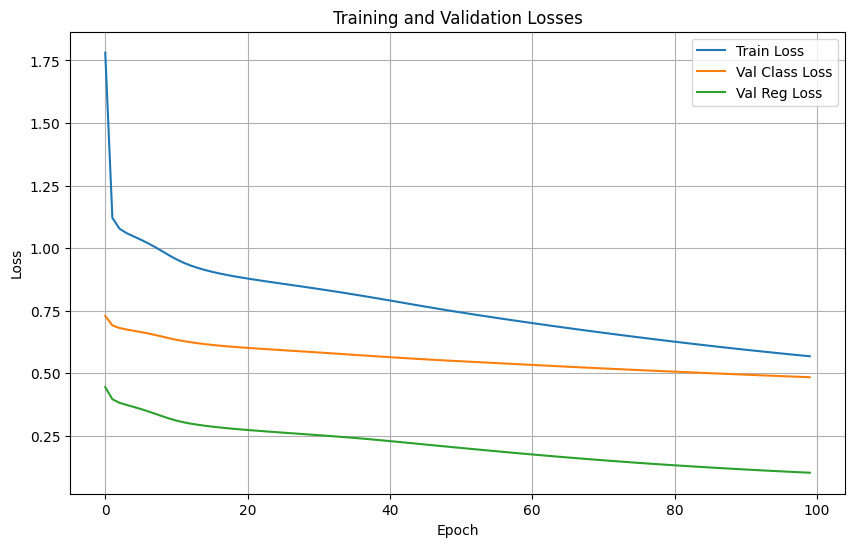

In [20]:
train_losses = []
val_losses_class = []
val_losses_reg = []

num_epochs = 100

inference_times = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []
    for X, y_class, y_reg in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        X, y_class, y_reg = X.to(device), y_class.to(device), y_reg.to(device)

        optimizer.zero_grad()
        outputs_class, outputs_reg = model(X)
        loss_class = criterion_class(outputs_class, y_class)
        loss_reg = criterion_reg(outputs_reg.squeeze(), y_reg)
        loss = loss_class + loss_reg
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

    train_losses.append(np.mean(epoch_train_losses))

    model.eval()
    val_loss_class = 0
    val_loss_reg = 0
    with torch.no_grad():
        for X, y_class, y_reg in tqdm(val_loader, desc=f'Validation'):
            X, y_class, y_reg = X.to(device), y_class.to(device), y_reg.to(device)
            outputs_class, outputs_reg = model(X)
            loss_class = criterion_class(outputs_class, y_class)
            loss_reg = criterion_reg(outputs_reg.squeeze(), y_reg)
            val_loss_class += loss_class.item()
            val_loss_reg += loss_reg.item()

    val_losses_class.append(val_loss_class / len(val_loader))
    val_losses_reg.append(val_loss_reg / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Class Loss: {val_losses_class[-1]:.4f}, Val Reg Loss: {val_losses_reg[-1]:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses_class, label='Val Class Loss')
plt.plot(val_losses_reg, label='Val Reg Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
test_loss_class = 0
test_loss_reg = 0
num_samples = len(test_loader.dataset)

with torch.no_grad():
    for X, y_class, y_reg in tqdm(test_loader, desc='Testing'):
        X, y_class, y_reg = X.to(device), y_class.to(device), y_reg.to(device)

        start_time = time.time()
        outputs_class, outputs_reg = model(X)
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)

        loss_class = criterion_class(outputs_class, y_class)
        loss_reg = criterion_reg(outputs_reg.squeeze(), y_reg)
        test_loss_class += loss_class.item()
        test_loss_reg += loss_reg.item()

print(f'Test Class Loss: {test_loss_class / len(test_loader):.4f}, Test Reg Loss: {test_loss_reg / len(test_loader):.4f}')


mean_inference_time = np.mean(inference_times)
print(f'Mean Inference Time per Sample: {mean_inference_time:.6f} seconds')
print(f'Total Number of Samples: {num_samples}')
print(f'Total Inference Time: {np.sum(inference_times):.2f} seconds')


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 26.36it/s]

Test Class Loss: 0.8965, Test Reg Loss: 0.4334
Mean Inference Time per Sample: 0.000743 seconds
Total Number of Samples: 1757
Total Inference Time: 0.04 seconds


In [22]:
test_loss_class = 0
test_loss_reg = 0
predictions_class = []
true_class = []

with torch.no_grad():
    for X, y_class, y_reg in tqdm(test_loader, desc='Testing'):
        X, y_class, y_reg = X.to(device), y_class.to(device), y_reg.to(device)
        outputs_class, outputs_reg = model(X)
        loss_class = criterion_class(outputs_class, y_class)
        loss_reg = criterion_reg(outputs_reg.squeeze(), y_reg)
        test_loss_class += loss_class.item()
        test_loss_reg += loss_reg.item()

        _, predicted = torch.max(outputs_class, 1)
        predictions_class.extend(predicted.cpu().numpy())
        true_class.extend(y_class.cpu().numpy())

print(f'Test Class Loss: {test_loss_class/len(test_loader):.4f}, Test Reg Loss: {test_loss_reg/len(test_loader):.4f}')


conf_matrix = confusion_matrix(true_class, predictions_class)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(true_class, predictions_class))

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 24.83it/s]

Test Class Loss: 0.8965, Test Reg Loss: 0.4334
Confusion Matrix:
[[   0    0    0    0    0    5    0    0    0]
 [   0    0    0    0    0    4    4    0    3]
 [   0    0    2    0    1   65    0    0    0]
 [   0    0    1   87    1   48    1   23    0]
 [   0    0    5    0    1   24    0    0    0]
 [  16    0    2    2    5 1119   38    2    2]
 [   1    0    0    0    0  204   35    1    0]
 [   0    0    0   12    0    0    0   43    0]
 [   0    0    0    0    0    0    0    0    0]]
Classification Report:
              precision    recall  f1-score   support

           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        11
           7       0.20      0.03      0.05        68
           8       0.86      0.54      0.66       161
           9       0.12      0.03      0.05        30
          12       0.76      0.94      0.84      1186
          15       0.45      0.15      0.22       241
          17       0.62      0.78      0.69   


C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muham

In [23]:
len(true_class)

1757

In [24]:
len(test_df)

1758

In [25]:
test_df.shape

(1758, 12)

In [55]:
true_class_text = label_encoder.inverse_transform(true_class)
predicted_class_text = label_encoder.inverse_transform(predictions_class)


conf_matrix = confusion_matrix(true_class_text, predicted_class_text)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(true_class_text, predicted_class_text))

Confusion Matrix:
[[   0    0    0    0    0    5    0    0    0]
 [   0    0    0    0    0    4    4    0    3]
 [   0    0    2    0    1   65    0    0    0]
 [   0    0    1   87    1   48    1   23    0]
 [   0    0    5    0    1   24    0    0    0]
 [  16    0    2    2    5 1119   38    2    2]
 [   1    0    0    0    0  204   35    1    0]
 [   0    0    0   12    0    0    0   43    0]
 [   0    0    0    0    0    0    0    0    0]]
Classification Report:
                     precision    recall  f1-score   support

           Dolomite       0.00      0.00      0.00         5
dolomitic_limestone       0.00      0.00      0.00        11
    dolomitic_shale       0.20      0.03      0.05        68
           mudstone       0.86      0.54      0.66       161
          oil_shale       0.12      0.03      0.05        30
              shale       0.76      0.94      0.84      1186
    shaly_limestone       0.45      0.15      0.22       241
          siltstone       0.62      0

C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muhamm

In [27]:
label_encoder.inverse_transform([0])[0]

' dolomitic_limestone'

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 25.89it/s]


Test Class Loss: 0.8965, Test Reg Loss: 0.4334


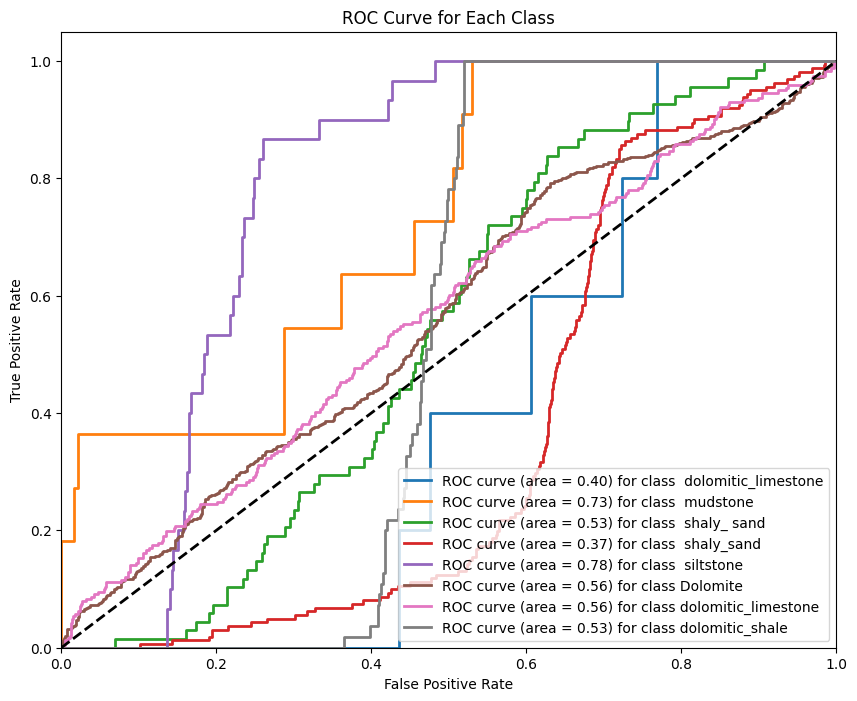

Confusion Matrix:
[[   0    0    0    0    0    5    0    0    0]
 [   0    0    0    0    0    4    4    0    3]
 [   0    0    2    0    1   65    0    0    0]
 [   0    0    1   87    1   48    1   23    0]
 [   0    0    5    0    1   24    0    0    0]
 [  16    0    2    2    5 1119   38    2    2]
 [   1    0    0    0    0  204   35    1    0]
 [   0    0    0   12    0    0    0   43    0]
 [   0    0    0    0    0    0    0    0    0]]
Classification Report:
              precision    recall  f1-score   support

           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        11
           7       0.20      0.03      0.05        68
           8       0.86      0.54      0.66       161
           9       0.12      0.03      0.05        30
          12       0.76      0.94      0.84      1186
          15       0.45      0.15      0.22       241
          17       0.62      0.78      0.69        55
          19       0.00      0.00      

C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muhammad Talha Imran\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muhamm

In [56]:
test_loss_class = 0
test_loss_reg = 0
predictions_class_prob = []
true_class = []

with torch.no_grad():
    for X, y_class, y_reg in tqdm(test_loader, desc='Testing'):
        X, y_class, y_reg = X.to(device), y_class.to(device), y_reg.to(device)
        outputs_class, outputs_reg = model(X)
        loss_class = criterion_class(outputs_class, y_class)
        loss_reg = criterion_reg(outputs_reg.squeeze(), y_reg)
        test_loss_class += loss_class.item()
        test_loss_reg += loss_reg.item()

        probabilities = torch.softmax(outputs_class, dim=1)
        predictions_class_prob.extend(probabilities.cpu().numpy())
        true_class.extend(y_class.cpu().numpy())

print(f'Test Class Loss: {test_loss_class/len(test_loader):.4f}, Test Reg Loss: {test_loss_reg/len(test_loader):.4f}')

predictions_class_prob = np.array(predictions_class_prob)
true_class = np.array(true_class)


true_class_binarized = label_binarize(true_class, classes=np.unique(true_class))

n_classes = true_class_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_class_binarized[:, i], predictions_class_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {label_encoder.inverse_transform([i])[0]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


conf_matrix = confusion_matrix(true_class, predictions_class_prob.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(true_class, predictions_class_prob.argmax(axis=1)))

In [68]:
test_loss_class = 0
test_loss_reg = 0
predictions_class = []
predictions_reg = []
true_class = []

with torch.no_grad():
    for X, y_class, y_reg in tqdm(test_loader, desc='Testing'):
        X, y_class, y_reg = X.to(device), y_class.to(device), y_reg.to(device)
        outputs_class, outputs_reg = model(X)
        
        _, predicted_class = torch.max(outputs_class, 1)
        predictions_class.extend(predicted_class.cpu().numpy())
        
        predictions_reg.extend(outputs_reg.squeeze().cpu().numpy())
        true_class.extend(y_class.cpu().numpy())

print(f'Test Class Loss: {test_loss_class / len(test_loader):.4f}, Test Reg Loss: {test_loss_reg / len(test_loader):.4f}')


test_file = './data/GY10HC.csv'
test_df = pd.read_csv(test_file)

predicted_class_text = label_encoder.inverse_transform(predictions_class)

print(len(predicted_class_text))
print(len(predictions_reg))
print(len(test_df))

if len(predicted_class_text) != len(test_df):
    print("Length mismatch detected. Adjusting predictions or DataFrame size.")
    test_df = test_df.iloc[:len(predicted_class_text)]
    print(f"Adjusted DataFrame length: {len(test_df)}")


output_df = test_df.copy()
output_df['predicted_Facies'] = predicted_class_text
output_df['predicted_TOC'] = predictions_reg


def reverse_normalize(df, normalization_params):
    toc_params = normalization_params['TOC']
    if 'predicted_TOC' in df.columns:
        df['predicted_TOC'] = df['predicted_TOC'] * toc_params['std'] + toc_params['mean']
    return df

output_df = reverse_normalize(output_df, normalization_params)


output_csv = './predictions.csv'
output_df.to_csv(output_csv, index=False)

print(f'Predictions saved to {output_csv}')


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 24.79it/s]

Test Class Loss: 0.0000, Test Reg Loss: 0.0000
1757
1757
1761
Length mismatch detected. Adjusting predictions or DataFrame size.
Adjusted DataFrame length: 1757
Predictions saved to ./predictions.csv


In [58]:
true_class_binarized = label_binarize(true_class, classes=np.unique(true_class))

n_classes = true_class_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_class_binarized[:, i], predictions_class_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [59]:
test_loss_reg = 0
true_reg = []
predictions_reg = []


with torch.no_grad():
    for X, y_class, y_reg in tqdm(test_loader, desc='Testing'):
        X, y_class, y_reg = X.to(device), y_class.to(device), y_reg.to(device)
        outputs_class, outputs_reg = model(X)
        loss_reg = criterion_reg(outputs_reg.squeeze(), y_reg)
        test_loss_reg += loss_reg.item()

        true_reg.extend(y_reg.cpu().numpy())
        predictions_reg.extend(outputs_reg.cpu().numpy())

true_reg = np.array(true_reg)
predictions_reg = np.array(predictions_reg).squeeze()

mae = mean_absolute_error(true_reg, predictions_reg)
mse = mean_squared_error(true_reg, predictions_reg)
r2 = r2_score(true_reg, predictions_reg)


print(f'Test Reg Loss: {test_loss_reg/len(test_loader):.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R²): {r2:.4f}')


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 25.59it/s]

Test Reg Loss: 0.4334
Mean Absolute Error (MAE): 0.5117
Mean Squared Error (MSE): 0.4341
R-squared (R²): 0.5385


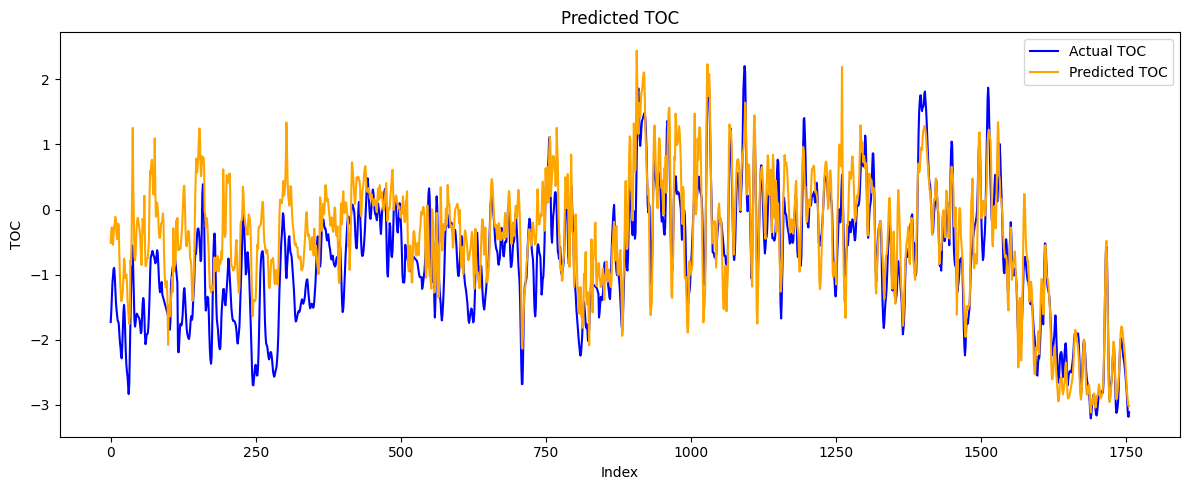

In [61]:
true_reg = []
predictions_reg = []

with torch.no_grad():
    for X, y_class, y_reg in test_loader:
        X = X.to(device)  
        y_reg = y_reg.numpy() 

        outputs_class, outputs_reg = model(X)
        predictions_reg.extend(outputs_reg.cpu().numpy())

        true_reg.extend(y_reg.tolist())


true_reg = np.array(true_reg)
predictions_reg = np.array(predictions_reg).squeeze()


plt.figure(figsize=(12, 5))


plt.plot(true_reg, label='Actual TOC', color='blue')
plt.xlabel('Index')
plt.ylabel('TOC')
plt.title('Actual TOC')
plt.legend()


plt.plot(predictions_reg, label='Predicted TOC', color='orange')
plt.xlabel('Index')
plt.ylabel('TOC')
plt.title('Predicted TOC')
plt.legend()

plt.tight_layout()
plt.show()


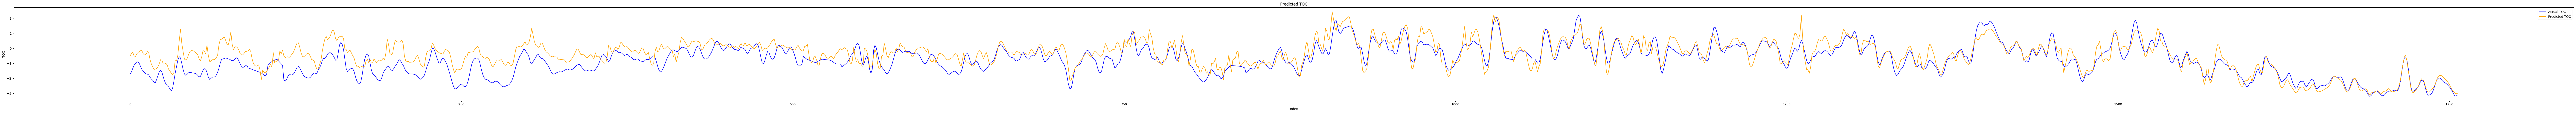

In [62]:
plt.figure(figsize=(112, 5))


plt.plot(true_reg, label='Actual TOC', color='blue')
plt.xlabel('Index')
plt.ylabel('TOC')
plt.title('Actual TOC')
plt.legend()


plt.plot(predictions_reg, label='Predicted TOC', color='orange')
plt.xlabel('Index')
plt.ylabel('TOC')
plt.title('Predicted TOC')
plt.legend()

plt.tight_layout()
plt.show()

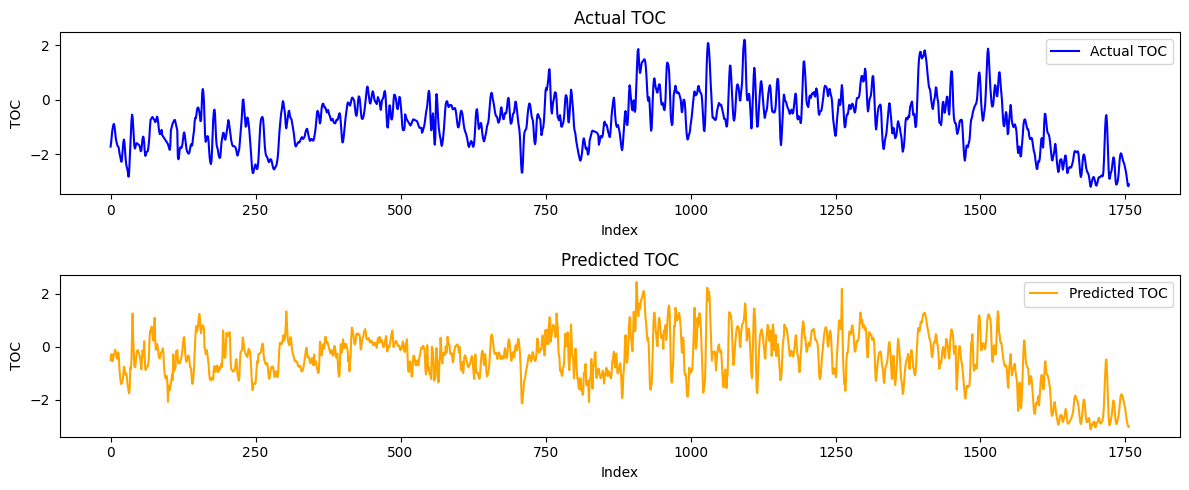

In [63]:
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(true_reg, label='Actual TOC', color='blue')
plt.xlabel('Index')
plt.ylabel('TOC')
plt.title('Actual TOC')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(predictions_reg, label='Predicted TOC', color='orange')
plt.xlabel('Index')
plt.ylabel('TOC')
plt.title('Predicted TOC')
plt.legend()

plt.tight_layout()
plt.show()


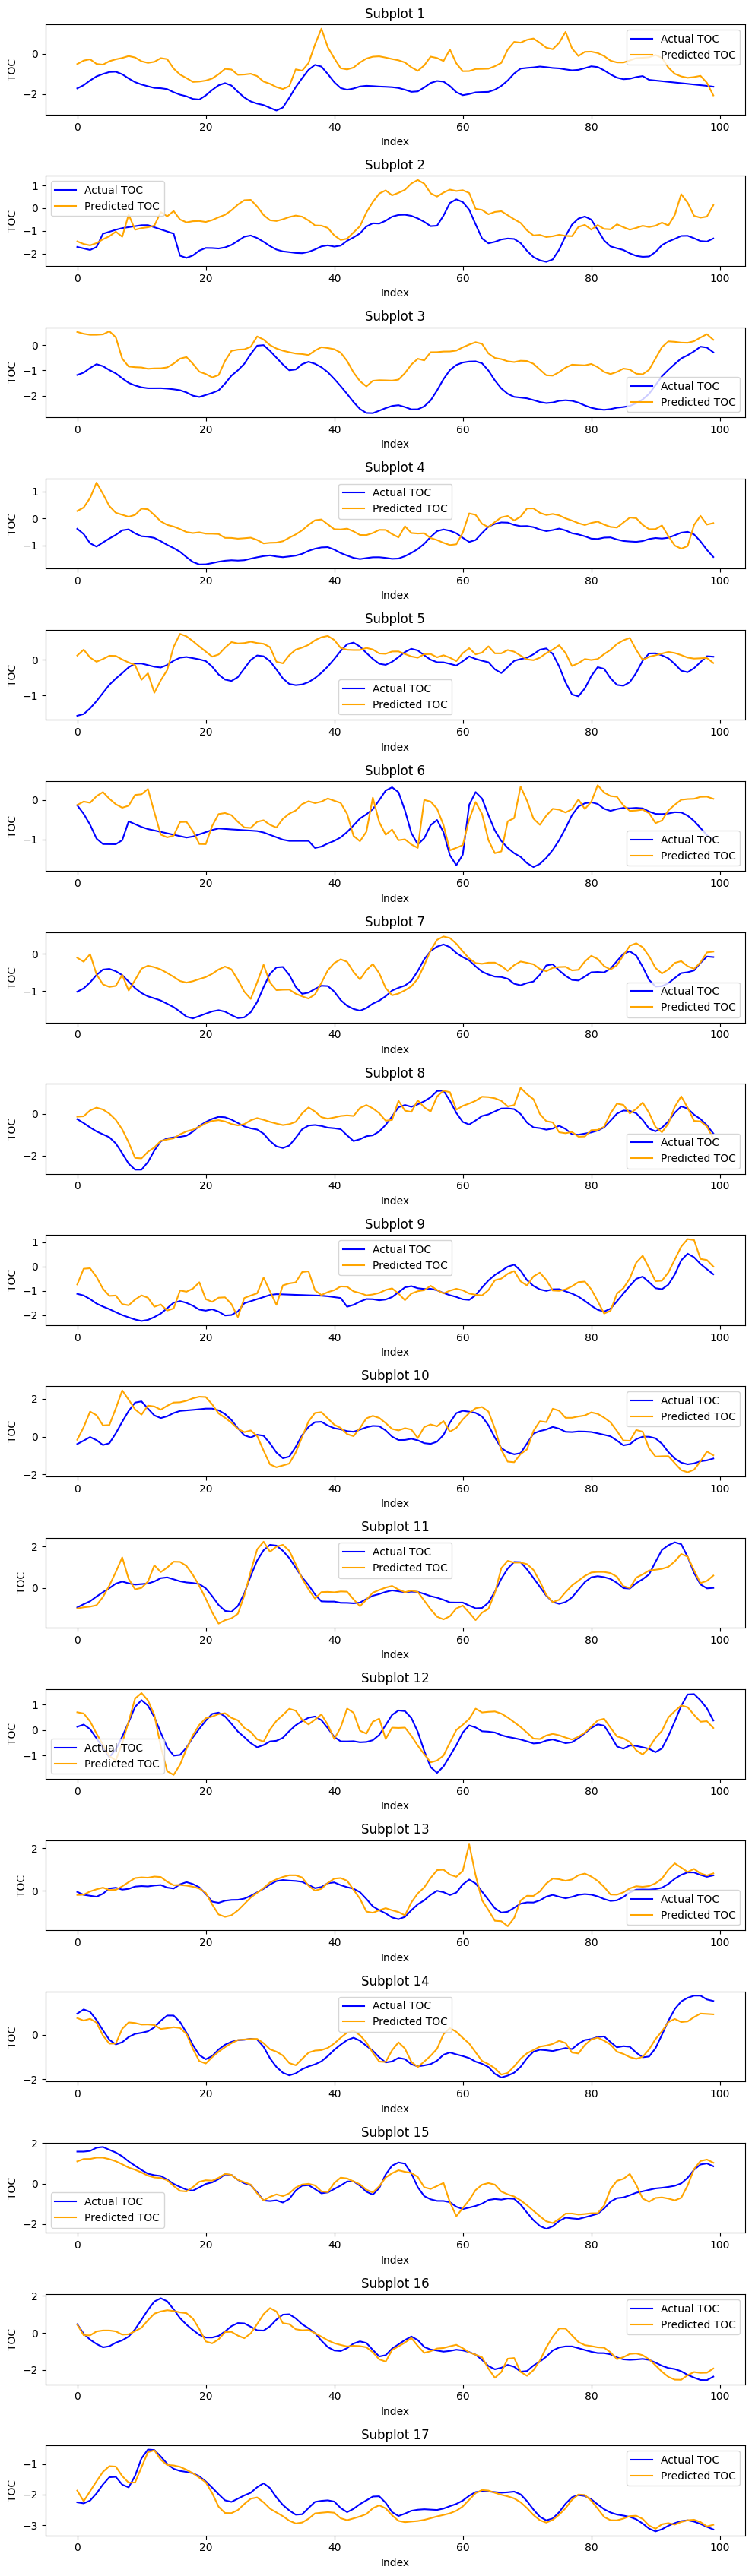

In [64]:
num_subplots = len(true_reg) // 100


fig, axs = plt.subplots(num_subplots, 1, figsize=(10, 2 * num_subplots))


for i in range(num_subplots):
    start_idx = i * 100
    end_idx = (i + 1) * 100
    axs[i].plot(true_reg[start_idx:end_idx], label='Actual TOC', color='blue')
    axs[i].plot(predictions_reg[start_idx:end_idx], label='Predicted TOC', color='orange')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('TOC')
    axs[i].set_title(f'Subplot {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [65]:
model_save_path = 'lstm_model_well_data.pth'
metadata_save_path = 'lstm_metadata_well_data.pkl'


torch.save(model.state_dict(), model_save_path)


metadata = {
    'feature_order': features,
    'normalization_params': normalization_params,
    'label_encoder': label_encoder
}


with open(metadata_save_path, 'wb') as f:
    pickle.dump(metadata, f)

print(f'Model saved to {model_save_path}')
print(f'Metadata (feature order, normalization parameters, label encoder) saved to {metadata_save_path}')


Model saved to lstm_model_well_data.pth
Metadata (feature order, normalization parameters, label encoder) saved to lstm_metadata_well_data.pkl


In [66]:
model_save_path = './lstm_model_well_data.pth'
metadata_save_path = './lstm_metadata_well_data.pkl'

with open(metadata_save_path, 'rb') as f:
    metadata = pickle.load(f)

feature_order = metadata['feature_order']
normalization_params = metadata['normalization_params']
label_encoder = metadata['label_encoder']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 64
num_layers = 2
model = LSTMNet(len(feature_order), hidden_size, num_layers, len(label_encoder.classes_)).to(device)


# model = LSTMNet(input_size, hidden_size, num_layers, num_classes)

model.load_state_dict(torch.load(model_save_path))

model.eval()

print('Model and metadata loaded successfully.')

Model and metadata loaded successfully.


In [67]:
test_loss_reg = 0
true_reg = []
predictions_reg = []


with torch.no_grad():
    for X, y_class, y_reg in tqdm(test_loader, desc='Testing'):
        X, y_class, y_reg = X.to(device), y_class.to(device), y_reg.to(device)
        outputs_class, outputs_reg = model(X)
        loss_reg = criterion_reg(outputs_reg.squeeze(), y_reg)
        test_loss_reg += loss_reg.item()

        true_reg.extend(y_reg.cpu().numpy())
        predictions_reg.extend(outputs_reg.cpu().numpy())

true_reg = np.array(true_reg)
predictions_reg = np.array(predictions_reg).squeeze()

mae = mean_absolute_error(true_reg, predictions_reg)
mse = mean_squared_error(true_reg, predictions_reg)
r2 = r2_score(true_reg, predictions_reg)


print(f'Test Reg Loss: {test_loss_reg/len(test_loader):.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R²): {r2:.4f}')


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 23.69it/s]

Test Reg Loss: 0.4334
Mean Absolute Error (MAE): 0.5117
Mean Squared Error (MSE): 0.4341
R-squared (R²): 0.5385
